# 1. Data Loading and preprocessing

### 1.1 Reading data from the source file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from hac import HAC
from pca import PCA
from kmeans import KMeans
from dbscan import DBSCAN
from metrics import silhouette_score, davies_bouldin_score

In [2]:
file_path = "data/breast-cancer-wisconsin.data"

df = pd.read_csv(file_path, names=['Sample_code_number', 
                                    'Clump_thickness', 
                                    'Uniformity_of_cell_size', 
                                    'Uniformity_of_cell_shape', 
                                    'Marginal_adhesion',
                                    'Single_epithelial_cell_size',
                                    'Bare_nuclei',
                                    'Bland_chromatin',
                                    'Normal_nucleoli',
                                    'Mitoses',
                                    'Class'])

# 2. EDA

### 2.1 Data description

In [3]:
df.describe()

,Sample_code_number,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bland_chromatin,Normal_nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [4]:
print(df.nunique(), '\n')
print(df.info())

Sample_code_number             645
Clump_thickness                 10
Uniformity_of_cell_size         10
Uniformity_of_cell_shape        10
Marginal_adhesion               10
Single_epithelial_cell_size     10
Bare_nuclei                     11
Bland_chromatin                 10
Normal_nucleoli                 10
Mitoses                          9
Class                            2
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample_code_number           699 non-null    int64 
 1   Clump_thickness              699 non-null    int64 
 2   Uniformity_of_cell_size      699 non-null    int64 
 3   Uniformity_of_cell_shape     699 non-null    int64 
 4   Marginal_adhesion            699 non-null    int64 
 5   Single_epithelial_cell_size  699 non-null    int64 
 6   Bare_nuclei                  699 n

### 2.2 Pre-processing: dealing with missing values

In [5]:
# Sample code number carries no predictive information for our task
x = df.drop(["Sample_code_number"], axis=1).dropna()

# data description states that missing values are replaces with '?'
# as there are only 16 rows with missing values, we decided that it is 
# safe to drop those values

x = x.replace('?', np.nan)
missing_count = x.isna().sum().sum()
print(f"Number of rows with missing values: {missing_count}")
x = x.dropna()
x = x.reset_index(drop=True)

Number of rows with missing values: 16


In [6]:
# classes are the target variables (benign/malignant)
classes = x["Class"]
x = x.drop(["Class"], axis=1)

In [7]:
# to convert the column from object to int64 data type for later convenience
x['Bare_nuclei'] = pd.to_numeric(x['Bare_nuclei'], errors='coerce').astype('Int64')
X = x.copy()

### 2.3 Visual investigation: Distribution of features

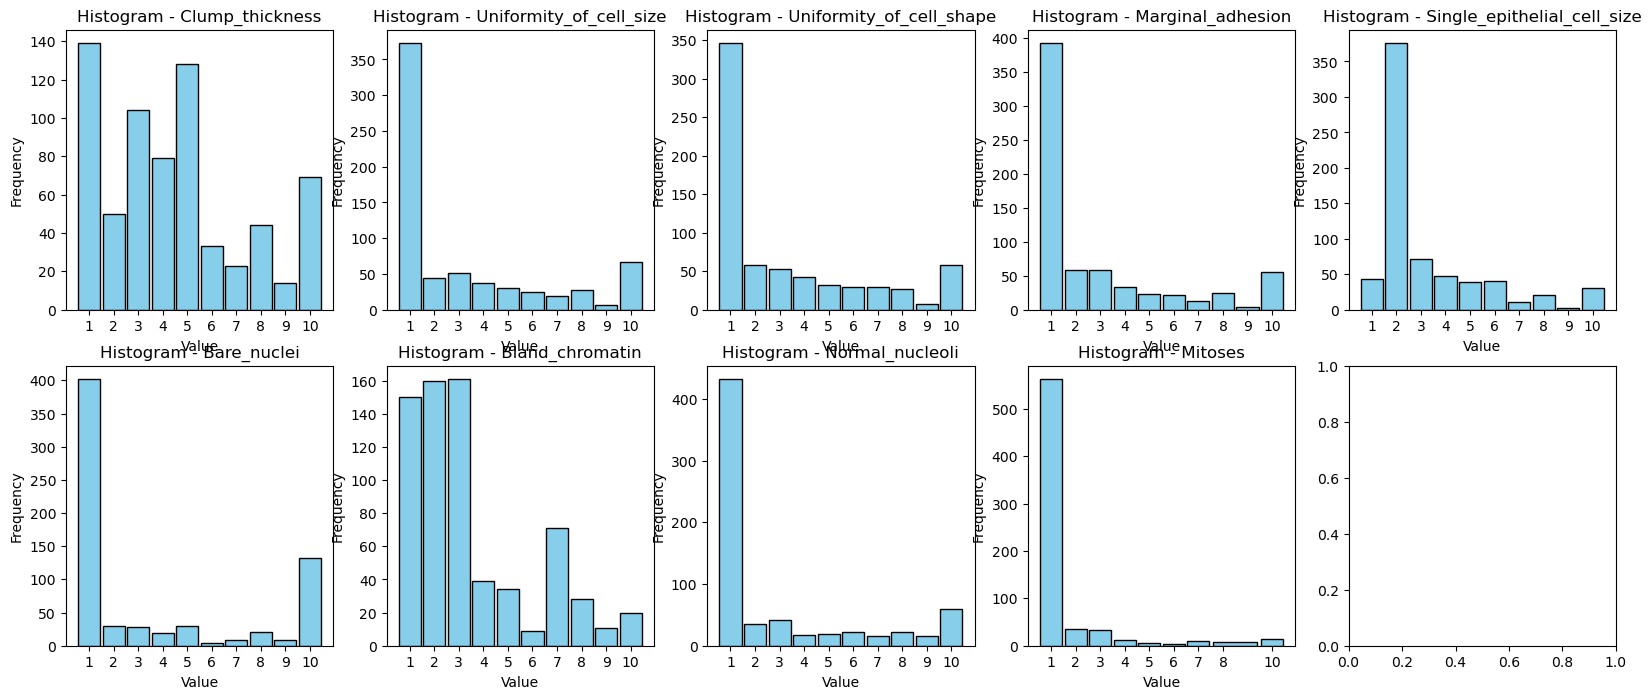

In [8]:
columns = [
    "Clump_thickness",
    "Uniformity_of_cell_size",
    "Uniformity_of_cell_shape",
    "Marginal_adhesion",
    "Single_epithelial_cell_size",
    "Bare_nuclei",
    "Bland_chromatin",
    "Normal_nucleoli",
    "Mitoses",
]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    
    # 1) Get unique values from that column
    unique_values = sorted(set(x[col]))

    # 2) Build the bins from unique_values
    if len(unique_values) == 1:
        bins = [unique_values[0] - 0.5, unique_values[0] + 0.5]
    else:
        bins = [val - 0.5 for val in unique_values] + [unique_values[-1] + 0.5]

    # 3) Plot only that column’s data
    ax.hist(x[col], bins=bins, edgecolor='black', rwidth=0.9, color='skyblue')

    ax.set_title(f"Histogram - {col}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xticks(unique_values)


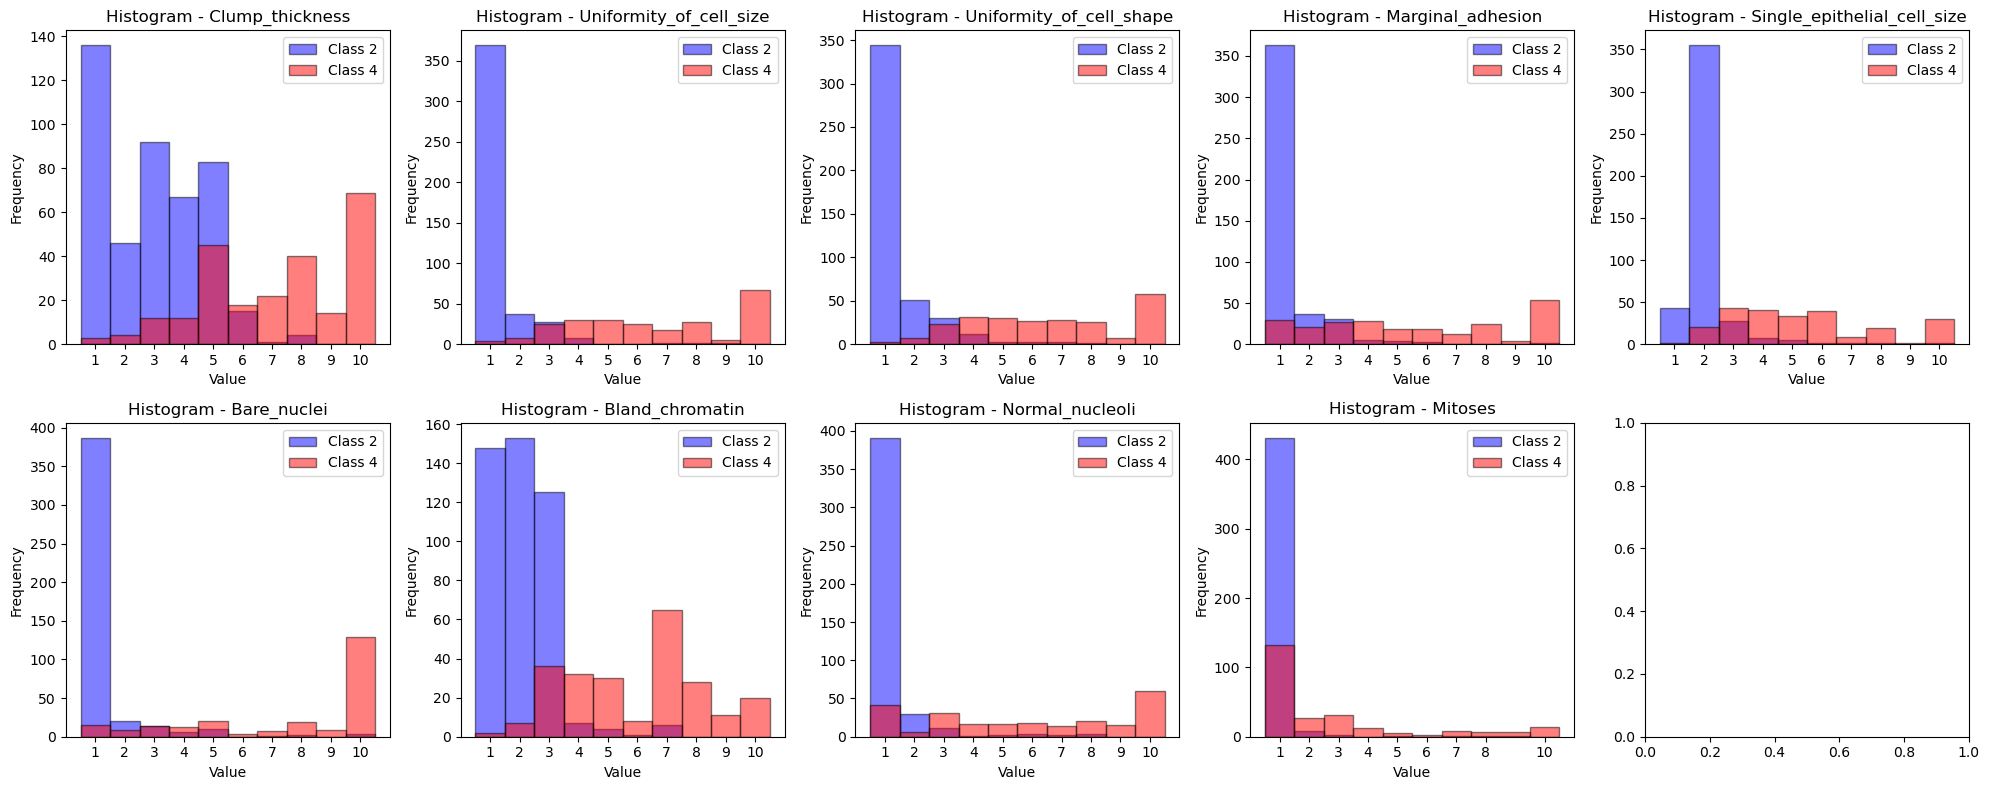

In [9]:
unique_classes = classes.unique() 
colors = ['blue', 'red']          

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(columns):
    ax = axes[i]
    
    feature_data = x[col].dropna()
    unique_vals = sorted(feature_data.unique())
    
    if len(unique_vals) == 1:
        # Edge case: if there's effectively only 1 unique value
        bins = [unique_vals[0] - 0.5, unique_vals[0] + 0.5]
    else:
        bins = [v - 0.5 for v in unique_vals] + [unique_vals[-1] + 0.5]
    
    # Plot each class's distribution on the same subplot
    for class_label, color in zip(unique_classes, colors):
        subset = x[col][classes == class_label].dropna()
        ax.hist(
            subset,
            bins=bins,
            alpha=0.5,       # transparency
            color=color,
            label=f"Class {class_label}",
            edgecolor='black'
        )

    ax.set_title(f"Histogram - {col}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_xticks(unique_vals)
    ax.legend()

plt.tight_layout()
plt.show()


In [10]:
desc_by_class = X.groupby(classes).describe()
print(desc_by_class)

###
# desc_by_class.to_latex("table_descriptive_stats.tex", float_format="%.2f")
###

      Clump_thickness                                                 \
                count      mean       std  min  25%  50%   75%   max   
Class                                                                  
2               444.0  2.963964  1.672661  1.0  1.0  3.0   4.0   8.0   
4               239.0  7.188285  2.437907  1.0  5.0  8.0  10.0  10.0   

      Uniformity_of_cell_size            ... Normal_nucleoli       Mitoses  \
                        count      mean  ...             75%   max   count   
Class                                    ...                                 
2                       444.0  1.306306  ...             1.0   8.0   444.0   
4                       239.0  6.577406  ...             9.5  10.0   239.0   

                                                     
           mean       std  min  25%  50%  75%   max  
Class                                                
2      1.065315  0.509738  1.0  1.0  1.0  1.0   8.0  
4      2.602510  2.564495  1.0  

#### 2.4 Scaling

In [11]:
from preprocessing import StandardScaler

x = x.to_numpy()
x = x.astype(float)

sc = StandardScaler()
sc.fit(x)

X_scaled = sc.transform(x)

# 3. PCA

#### 3.1 Apply PCA on features

In [22]:
from pca import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
loadings = pca.loadings_

print("Explained variances: ", pca.explained_variance_ratio_)
print("Loadings: \n", loadings)

Explained variance:  [0.65549993 0.08621632]
Loadings: 
 [[ 0.734214    0.12411905]
 [ 0.92558151  0.04111456]
 [ 0.91777801  0.07265739]
 [ 0.80874072  0.04592244]
 [ 0.8172735  -0.14492642]
 [ 0.81443806  0.23030752]
 [ 0.84039725  0.20105515]
 [ 0.81571141 -0.02994169]
 [ 0.55955545 -0.79827052]]


#### 3.2 Visualization: PCA loadings

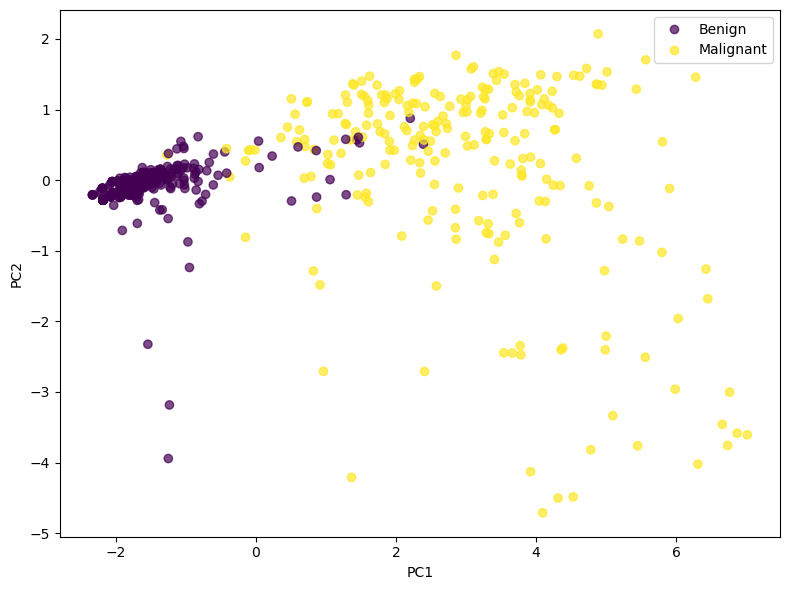

In [13]:
plt.figure(figsize=(8, 6))


scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=classes,                
    cmap='viridis',
    alpha=0.7
)

handles, _ = scatter.legend_elements()
labels = ["Benign", "Malignant"]

plt.legend(handles, labels, loc="best")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


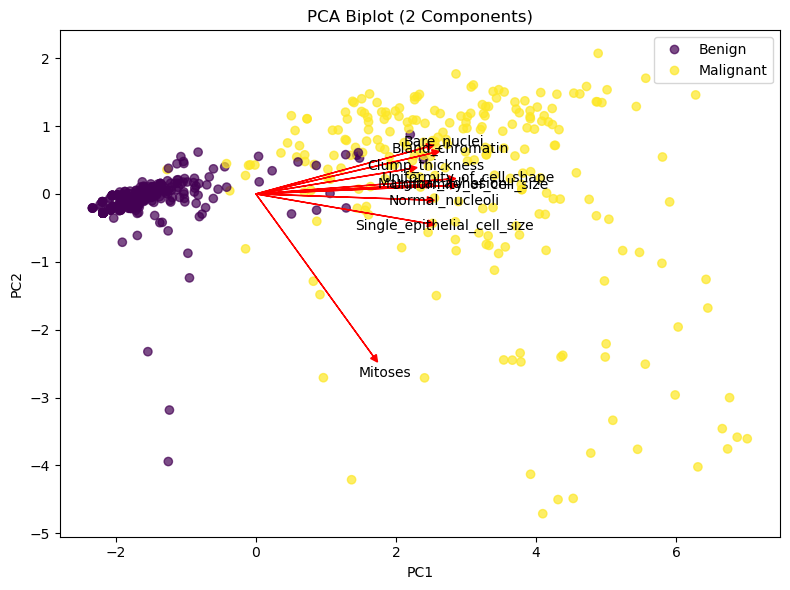

In [14]:
# X_pca shape: (n_samples, 2)
# pca.loadings_ shape: (n_features, 2)
# explained variance: pca.explained_variance_

# 1) Plot the data in PCA space
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=classes,          # color by class, if available
    cmap='viridis',
    alpha=0.7
)

handles, _ = scatter.legend_elements()
ax.legend(handles, ["Benign", "Malignant"], loc="best")
# Optionally create a legend or colorbar
# If 'classes' is numeric or ordinal, a colorbar might be better:
# plt.colorbar(scatter, label='Class')

# 2) Draw loadings arrows
loadings = pca.loadings_  # shape: (n_features, 2)
# Decide on a scale factor so the arrows are visually distinct
scalefactor = 3

# If you have the original column names:
feature_names = X.columns  # or a list of your feature names
for i, v in enumerate(loadings):
    # v is a length-2 vector: [loading on PC1, loading on PC2]
    ax.arrow(
        0, 0,               # start at origin
        scalefactor * v[0], # PC1 loading
        scalefactor * v[1], # PC2 loading
        color='red',
        head_width=0.1,
        head_length=0.1
    )
    ax.text(
        scalefactor * v[0] * 1.1,
        scalefactor * v[1] * 1.1,
        feature_names[i],   # label each arrow with the feature name
        color='black',
        ha='center',
        va='center'
    )


ax.set_xlabel(f"PC1")
ax.set_ylabel(f"PC2")
ax.set_title("PCA Biplot (2 Components)")

plt.tight_layout()
plt.show()


#### 3.3 Feature loadings as a table

In [18]:
# Analysis of loadings
loadings = pca.pcs_ * np.sqrt(pca.explained_variance_)
loadings

array([[ 0.734214  ,  0.12411905],
       [ 0.92558151,  0.04111456],
       [ 0.91777801,  0.07265739],
       [ 0.80874072,  0.04592244],
       [ 0.8172735 , -0.14492642],
       [ 0.81443806,  0.23030752],
       [ 0.84039725,  0.20105515],
       [ 0.81571141, -0.02994169],
       [ 0.55955545, -0.79827052]])

In [21]:
# Number of principal components
n_pcs = pca.pcs_.shape[1]

# Create principal component labels
pc_labels = [f"PC{i+1}" for i in range(n_pcs)]

# Create the DataFrame
loadings_df = pd.DataFrame(
    loadings.T,
    index=pc_labels,
    columns=feature_names
)

# Display the Loadings Table
print(loadings_df.round(3))


     Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape  \
PC1            0.734                    0.926                     0.918   
PC2            0.124                    0.041                     0.073   

     Marginal_adhesion  Single_epithelial_cell_size  Bare_nuclei  \
PC1              0.809                        0.817        0.814   
PC2              0.046                       -0.145        0.230   

     Bland_chromatin  Normal_nucleoli  Mitoses  
PC1            0.840            0.816    0.560  
PC2            0.201           -0.030   -0.798  


# 4. Clustering

#### 4.1 Hierarchical Agglomerative Clustering

In [34]:
from hac import HAC
from metrics import adjusted_rand_index, silhouette_score, davies_bouldin_score

# It has been found that linkage: complete, n_clusters: 2 gives the most optimal scores

params = {
    'n_clusters': [2, 3, 4, 5, 6],
    'linkage': ['single', 'complete'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

best_score = -np.inf
best_params = None
best_metrics = None

def evaluate_clustering(X, labels, true_labels):
    """
    Returns a dictionary of metrics for given clustering results.
    If you only want to use ARI for selection, focus on that in the final selection step.
    """
    results = {}
    results['ARI'] = adjusted_rand_index(true_labels, labels)
    results['Silhouette'] = silhouette_score(X, labels)
    results['DaviesBouldin'] = davies_bouldin_score(X, labels)
    return results


for linkage in params['linkage']:
        for affinity in params['metric']:

            for n_clusters in params['n_clusters']:
                # Initialize and fit the model
                clusterer = HAC(
                    n_clusters=n_clusters,
                    linkage=linkage,
                    metric=affinity
                )

                clusterer.fit(X_scaled)
                labels = clusterer.labels_

                # Evaluate
                metrics_dict = evaluate_clustering(X_scaled, labels, classes)

                # Decide which metric to maximize (e.g. ARI)
                score_for_selection = metrics_dict['ARI']

                if score_for_selection > best_score:
                    best_score = score_for_selection
                    best_params = {
                        'n_clusters': n_clusters,
                        'linkage': linkage,
                        'affinity': affinity
                    }
                    best_metrics = metrics_dict

# Print best results
print("Best ARI Score: {:.4f}".format(best_score))
print("Best Params:", best_params)
print("All Metrics for Best Params:", best_metrics)


KeyboardInterrupt: 

In [36]:
hac = HAC(linkage='complete', n_clusters=2)
hac.fit(X_scaled)

In [37]:
evaluate_clustering(X_scaled, hac.labels_, classes)

{'ARI': 0.4795023882073597,
 'Silhouette': 0.530781934844732,
 'DaviesBouldin': 0.9126819533757279}

#### 4.2 K-Means

In [ ]:
from kmeans import KMeans

# Define parameter grid for K-Means
params = {
    'n_clusters': [2, 3, 4, 5, 6]
}

# Initialize variables to store the best results
best_score = -np.inf
best_params = {}
best_metrics = {}

# Iterate over the number of clusters
for n_clusters in params['n_clusters']:
    # Initialize and fit the K-Means model
    clusterer = KMeans(
        n_clusters=n_clusters,
        max_iter=300,         
        tol=1e-4,             
    )
    
    clusterer.fit(X_scaled)
    labels = clusterer.labels_
    
    # Evaluate clustering performance
    metrics_dict = evaluate_clustering(X_scaled, labels, classes)
    
    # Select the metric to maximize (e.g., Adjusted Rand Index)
    score_for_selection = metrics_dict.get('ARI', 0)  # Ensure 'ARI' exists
    
    # Update best parameters if current score is better
    if score_for_selection > best_score:
        best_score = score_for_selection
        best_params = {
            'n_clusters': n_clusters
        }
        best_metrics = metrics_dict

# Print best results
print("Best ARI Score: {:.4f}".format(best_score))
print("Best Params:", best_params)
print("All Metrics for Best Params:", best_metrics)


Best ARI Score: 0.8575
Best Params: {'n_clusters': 2}
All Metrics for Best Params: {'ARI': 0.8575029605818916, 'Silhouette': 0.5724088085754669, 'DaviesBouldin': 0.8194633130937863}


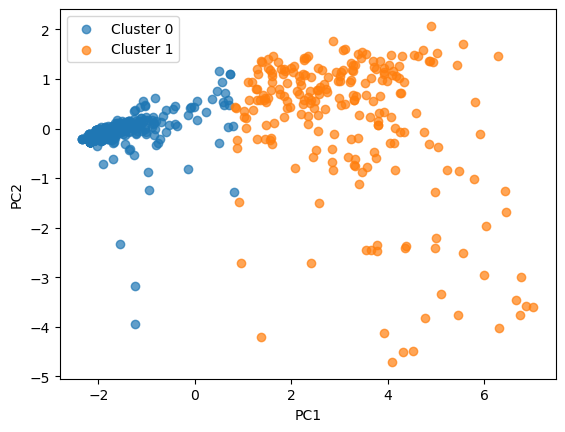

In [49]:

kmeans = KMeans(
        n_clusters=2,
        max_iter=300,         
        tol=1e-4,             
    )

kmeans.fit(X_scaled)
labels = kmeans.labels_
unique_labels = set(labels)
    
# Plot clusters
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {label}',
                alpha=0.7)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

#### 4.3 DBSCAN

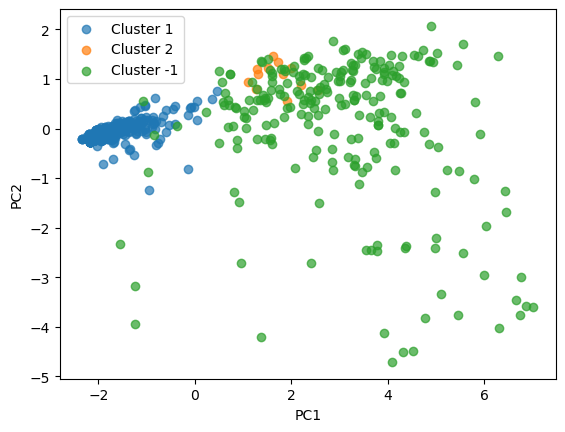

In [51]:
from dbscan import DBSCAN

dbscan = DBSCAN(eps=1.45, min_samples=7)
dbscan.fit(X_scaled)

labels = dbscan.labels_

unique_labels = set(labels)
    
# Plot clusters
for label in unique_labels:
    mask = (labels == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=f'Cluster {label}',
                alpha=0.7)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()